In [2]:
# imports

from obspy import UTCDateTime
import numpy as np
from obspy.clients.fdsn import Client
from obspy import Stream
from obspy.signal.util import next_pow_2
from obspy.geodetics import gps2dist_azimuth
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# set up

# Example  (Hawaii HV, 2018):
CENTER_LAT, CENTER_LON = 19.3, -155.5
STARTTIME = "2014-05-01T00:00:00"
ENDTIME   = "2016-12-31T23:59:59"

# Search radius (degrees) for HV stations around the center:
MAXRADIUS_DEG = 10.0

# Prefer inter-station distances in this range (km) for microseism band:
MIN_DIST_KM, MAX_DIST_KM = 100.0, 400.0

# Band of interest (volcano):
FREQMIN = 0.5   # Hz  (20 s)
FREQMAX = 10.0   # Hz  (5 s)

# Windowing and correlation
WINDOW_LENGTH = 24 * 3600     # seconds (one-day windows)
DEFAULT_MAX_LAG = 300         # seconds; will auto-bump based on pair distance
TIME_NORMALIZATION = "onebit" # "onebit", "ram", or None
RAM_WINDOW_SEC = 10

# Response removal (to velocity)
# PRE_FILT = (0.005, 0.006, 45.0, 50.0)
# WATER_LEVEL = 60

# creates a client that connects to the IRIS data center
client = Client("IRIS")


In [4]:
# fetch data
def fetch_stream(net, sta, loc, cha, t0, t1, client_name="IRIS", attach_resp=True):
    client = Client(client_name)
    st = client.get_waveforms(net, sta, loc, cha, t0, t1, attach_response = attach_resp)
    st.merge(fill_value="interpolate")
    return st

In [5]:
# Input station information

freqmin = 0.5   # Hz  (20 s)
freqmax = 10.0   # Hz  (5 s)

stt = UTCDateTime("2014-10-01T03:35:40")
edt = UTCDateTime("2014-10-01T03:35:43")

# network
net = 'XD'
# station
sta = 'ME02'
# location
loc = '*'
# channel
cha = 'HHZ'

# Get the waveforms from client
st = client.get_waveforms(net, sta, loc, cha, stt, edt)

- Demean removes a constant offset (non-zero average) from the time series.

- Detrend removes a linear ramp (often caused by instrument drift, timing issues, or long-period noise).

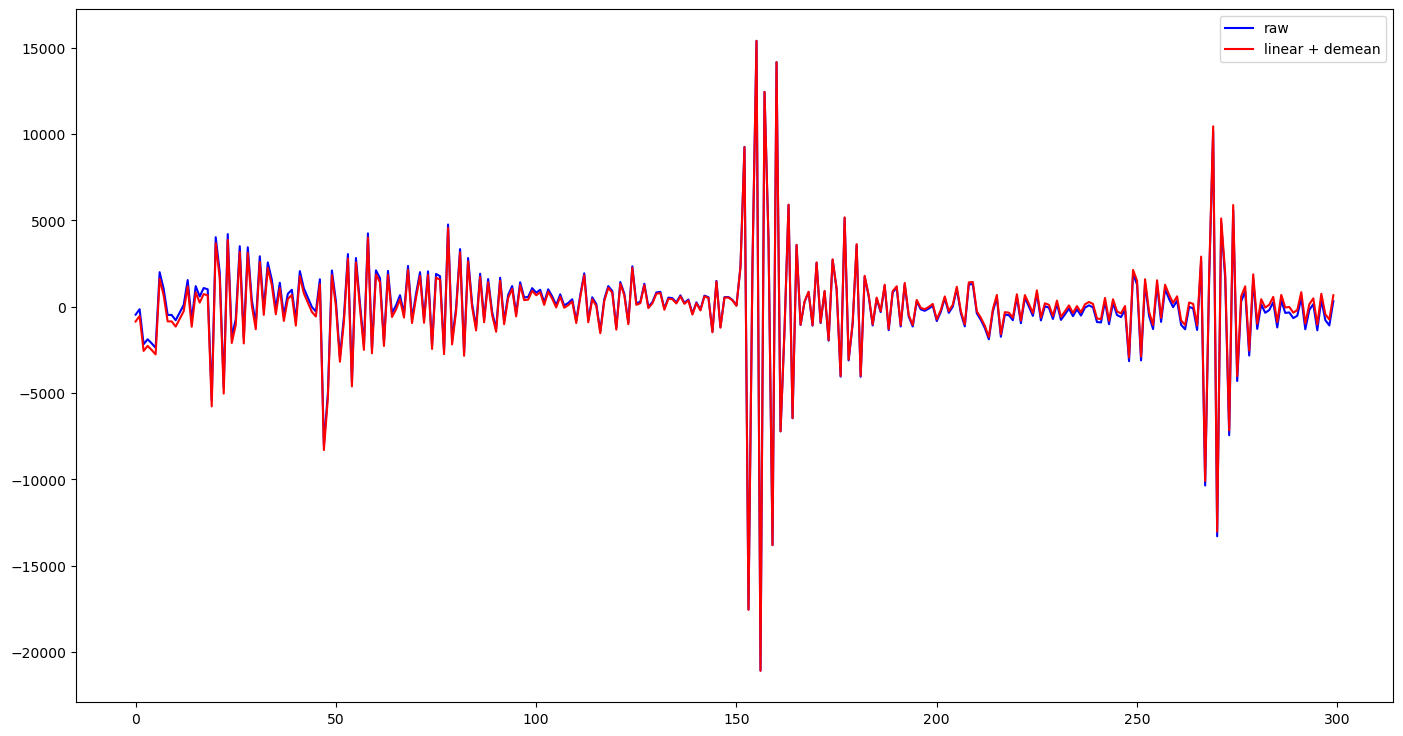

In [6]:
# detrend waveform
st_copy = st.copy()

st_detrend_linear = st_copy.detrend("linear")

st_detrend_mean = st_copy.detrend("demean")

st_detrend_combined = st_detrend_linear.detrend("demean")

plt.figure(figsize=(17,9))

# plot raw
for tr in st:
    data_raw = tr.data
plt.plot(data_raw,color='blue',label='raw')

# plot linear + mean
for tr in st_detrend_combined:
    data_combined = tr.data
plt.plot(data_combined,color='red',label="linear + demean")

plt.legend()

Taper smoothes the edges

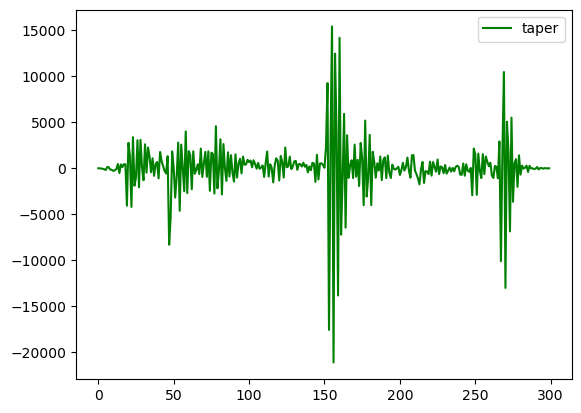

In [7]:
st_detrend_combined.taper(max(10.0 / st[0].stats.sampling_rate, 0.05))

for tr in st_detrend_combined:
    data_taper = tr.data
plt.plot(data_taper,color='green',label="taper")

plt.legend()

1. filter() Method Basics

OBspy’s filter() method (part of the Trace and Stream objects) applies various filters to seismic data. The most common filters are:

- Lowpass: Removes high-frequency noise.
- Highpass: Removes low-frequency noise or drift.
- Bandpass: Keeps only frequencies within a specified range.
- Bandstop: Removes frequencies within a specified range.

2. Key Filter Parameters


| Parameter | Description | Effect on Waveform |
|-----------|-------------|--------------------|
| type | Type of filter: 'lowpass', 'highpass', 'bandpass', 'bandstop' | Determines which frequencies are removed or retained. |
| freq | Corner frequency (for lowpass/highpass) or list of frequencies (for band) | Sets the cutoff frequency(ies) for the filter. |
| corners | Number of corners (order of the filter, e.g., 2, 4) | Higher values create a sharper cutoff but may introduce ringing. |
| zerophase | Boolean (True/False) | If True, applies the filter twice (forward and reverse) to remove phase shifts. |
    
4. What Each Filter Does

Lowpass Filter
- Parameters: type='lowpass', freq=5.0 (e.g., 5 Hz)
- Effect: Attenuates frequencies above the specified cutoff.
- Use Case: Removes high-frequency noise.

Highpass Filter
- Parameters: type='highpass', freq=1.0 (e.g., 1 Hz)
- Effect: Attenuates frequencies below the specified cutoff.
- Use Case: Removes low-frequency drift or long-period noise.

Bandpass Filter
- Parameters: type='bandpass', freq=[1.0, 20.0] (e.g., 1–20 Hz)
- Effect: Retains only frequencies within the specified range.
- Use Case: Focuses on a specific frequency band of interest.

Bandstop Filter
- Parameters: type='bandstop', freq=[49.0, 51.0] (e.g., 49–51 Hz)
- Effect: Removes frequencies within the specified range.
- Use Case: Eliminates powerline noise (e.g., 50/60 Hz).

4. Additional Parameters

corners: Controls the steepness of the filter. More corners = sharper cutoff, but may introduce artifacts.
zerophase: If True, the filter is applied in both directions, preserving the original phase of the signal (no phase shift).

5. Example Usage
python
Copy

from obspy import read
st = read("waveform.mseed")
st.filter('bandpass', freq=[1, 20], corners=4, zerophase=True)

This applies a 4th-order zero-phase bandpass filter between 1 and 20 Hz.

6. Practical Considerations

Corner Frequency: Choose based on your signal and noise characteristics.
Order (corners): Higher orders can distort the signal near the cutoff.
Zero-phase: Useful for preserving the timing of seismic phases, but doubles the computation.

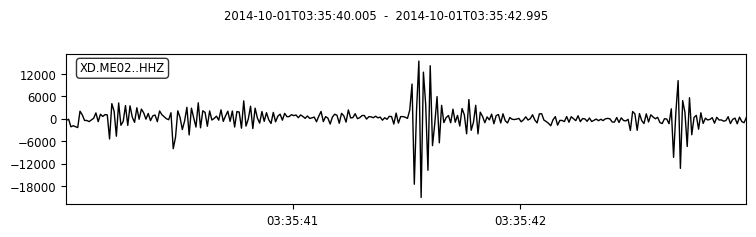

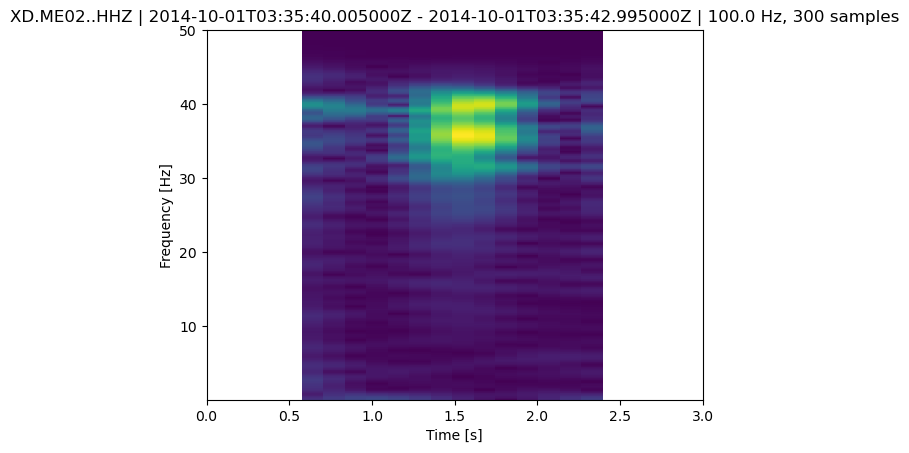

[None]

In [8]:
# plot original waveform

st.plot()
st.spectrogram()

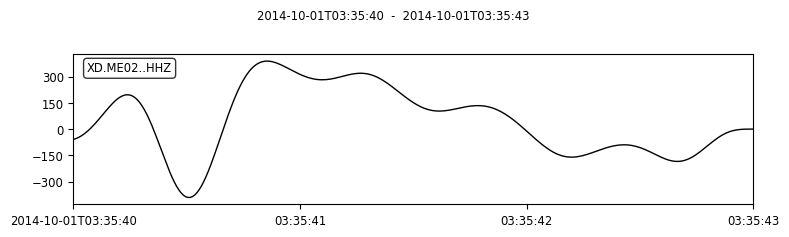

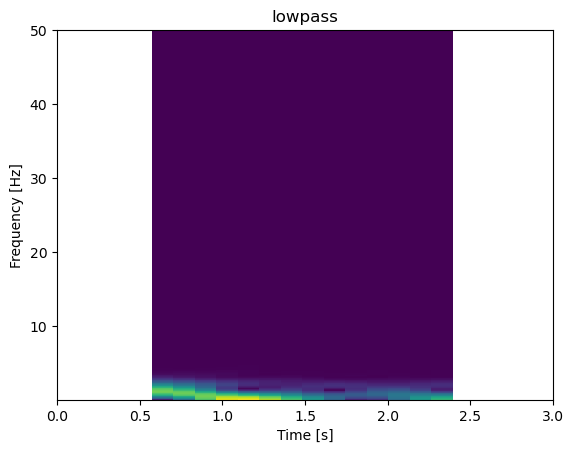

[None]

In [16]:
# What a low-pass filter does
# Preserves:
# Long-period signals (slow ground motion, broad waveforms)
#
# Suppresses:
#Short-period signals (sharp spikes, high-frequency noise)

st_lowpass = st_detrend_combined.copy()
st_lowpass.filter("lowpass", freq=2.0, corners=4, zerophase=True)
# st_lowpass.filter("lowpass",freq=1)
st_lowpass.plot(starttime=stt,endtime=edt)
st_lowpass.spectrogram(title='lowpass')

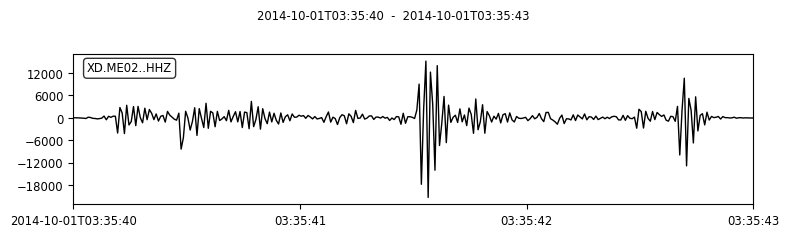

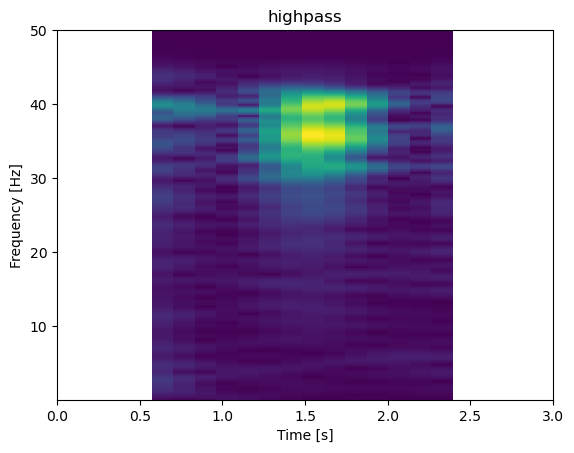

[None]

In [37]:
# Highpass filter
# freq is the corner frequency in Hz
# corners controls filter steepness
# zerophase=True avoids phase shift
st_highpass = st_detrend_combined.copy()
st_highpass.filter("highpass", freq=0.5, corners=4, zerophase=True)

st_highpass.plot(starttime=stt,endtime=edt)
st_highpass.spectrogram(title='highpass')

bandpass filter keeps only a specific range of frequencies in a seismic waveform and suppresses everything below and above that range.

What a bandpass filter does

Preserves:
Signal with periods/frequencies you care about

Removes:

Long-period trends and drift (low frequencies)

Short-period noise and spikes (high frequencies)

In frequency space, it acts like a window that passes only
freqmin → freqmax.

What it does in the time domain

After bandpass filtering, the waveform:

Becomes cleaner and more focused

Shows clearer arrivals in the target band

Has reduced noise before and after phases

Often looks more oscillatory (since only a narrow band remains)

Sharp steps and slow ramps disappear.

Why bandpass filters are used in seismology
1. Isolate specific seismic phases

P waves vs S waves

Body waves vs surface waves

2. Improve signal-to-noise ratio

Match filter band to where signal energy is strongest

3. Standardize waveforms

Make traces comparable across stations/events

4. Prepare for correlation or stacking

Removes frequencies that degrade coherence

Important side effects to understand
1. Apparent waveform shape changes

The filtered signal is not the original ground motion—it’s the ground motion in that frequency band.

2. Ringing

Caused by sharp filter corners or poor preprocessing

Reduced by detrending and tapering

3. Amplitude distortion

Absolute amplitudes are no longer physically meaningful unless corrected carefully

4. Phase effects

Zero-phase filters preserve arrival times but are non-causal

Causal filters shift arrivals

Where bandpass fits in preprocessing

Demean

Detrend

Taper

Bandpass filter

Analysis (picking, correlation, spectra, etc.)

How to choose the band (intuition)

Pick the frequency range where your signal is strong and noise is weak.

Examples:

Local events: higher frequencies → tighter band

Teleseismic events: lower frequencies → broader, lower band

Surface waves: very low frequencies → long periods

One-sentence intuition

A bandpass filter lets you “listen” to only one octave (or two) of Earth’s motion and ignore everything else.

If you want, tell me your event type, distance, and sampling rate, and I’ll suggest a bandpass that’s

In [20]:
tr=st[0]
print(f"Sampling Rate: {tr.stats.sampling_rate} Hz")

Sampling Rate: 100.0 Hz


In [23]:
freqmax = 0.5 * tr.stats.sampling_rate
print(f"nyquist: {freqmax}")

nyquist: 50.0


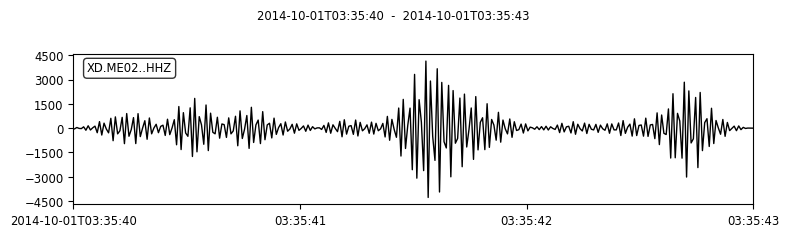

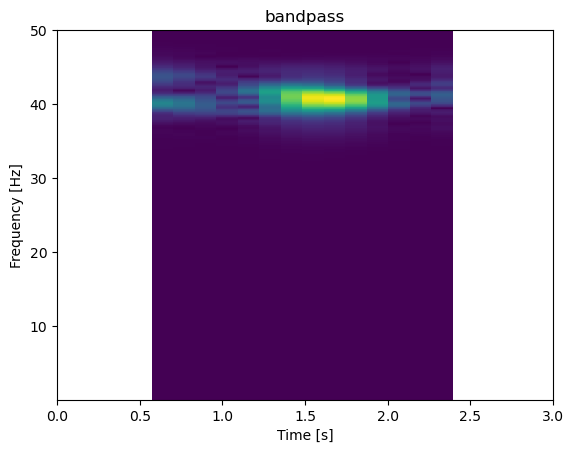

[None]

In [41]:
st_bandpass = st_detrend_combined.copy()
st_bandpass.filter("bandpass", freqmin=40, freqmax=49.0, corners=4, zerophase=True)

st_bandpass.plot(starttime=stt,endtime=edt)
st_bandpass.spectrogram(title='bandpass')